In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
from tqdm import tqdm
from rich import print as pprint
from sourcesep.utils.config import load_config
from aind_ophys_utils.dff import dff

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

In [2]:
# These are combined responses of autofluorescence, Ca sensor (EGFP), and DA sensor (mApple).

from sourcesep.sim import SimData
paths = load_config(dataset_key='all')
sim = SimData(T=100, cfg_path=paths['root'] /
              "sim_HSFP_670128_2023-04-27.toml")
_ = sim.get_S()
_ = sim.get_W()
_ = sim.get_E()
pprint(sim.W_df)

Paths are for dataset tagged: all
Paths are for dataset tagged: all


405     445     473     514     560
EGFP  0.1732  0.3915  0.8143  0.1469  0.0054

In [3]:
paths = load_config(dataset_key='all')
f = h5py.File(paths['root'] /
              'HSFP_670128_2023-04-27_data_preprocessed.hdf5', 'r')
print(f.keys())

xj = {}
for j in np.argsort(f['Lasers'][:]):
    xj[j] = f[f'Channel{j+1}'][:].astype(float)

t = f['Time'][:]
l = f['Wavelength'][:]
lasers = f['Lasers'][:][np.argsort(f['Lasers'][:])]

print(f'\nsampling frequency: {1/(np.max(t) / t.size):0.2f} Hz')
print(f'length of recording: {np.max(t)-np.min(t):0.2f} seconds')
print(f'\neach channel has dimensions of {xj[0].shape}')
print(f'min. wavelength: {np.min(l):0.2f} nm')
print(f'max. wavelength: {np.max(l):0.2f} nm')

Paths are for dataset tagged: all
<KeysViewHDF5 ['Channel1', 'Channel2', 'Channel3', 'Channel4', 'Channel5', 'Lasers', 'Time', 'Wavelength']>

sampling frequency: 23.99 Hz
length of recording: 448.23 seconds

each channel has dimensions of (10752, 300)
min. wavelength: 400.00 nm
max. wavelength: 699.00 nm


In [4]:
# laser intensity (close to emission peak of laser) is orders of magnitude
# larger than the signal intensity from indicators (close to emission peak of fluorophore).
# here we use aind utils to obtain the df/f and f0 signals independently for each pixel in each channel.

rel_xj = {}
f0_xj = {}
mean_per_px = {}

for j in range(len(xj)):
    dff_signal_list = []
    f0_signal_list = []
    for px in tqdm(range(xj[j].shape[1])):
        dff_signal, f0_signal, signal_sd = dff(xj[j][:,px], 
                                               fs=23.99, 
                                               long_window=20.0, 
                                               short_window=2.0, 
                                               inactive_percentile=5)
        # check if nan in dff_signal, set to a very small value if so
        if np.isnan(dff_signal).any():
            dff_signal = np.zeros(dff_signal.shape) + 1e-6*np.random.randn(dff_signal.shape[0])
        dff_signal = dff_signal + np.abs(np.min(dff_signal[dff_signal<0])) # if negative, push to 0
        dff_signal_list.append(dff_signal)
        f0_signal_list.append(f0_signal)
    
    rel_xj[j] = np.vstack(dff_signal_list).T
    f0_xj[j] = np.vstack(f0_signal_list).T

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:05<00:00, 52.03it/s]


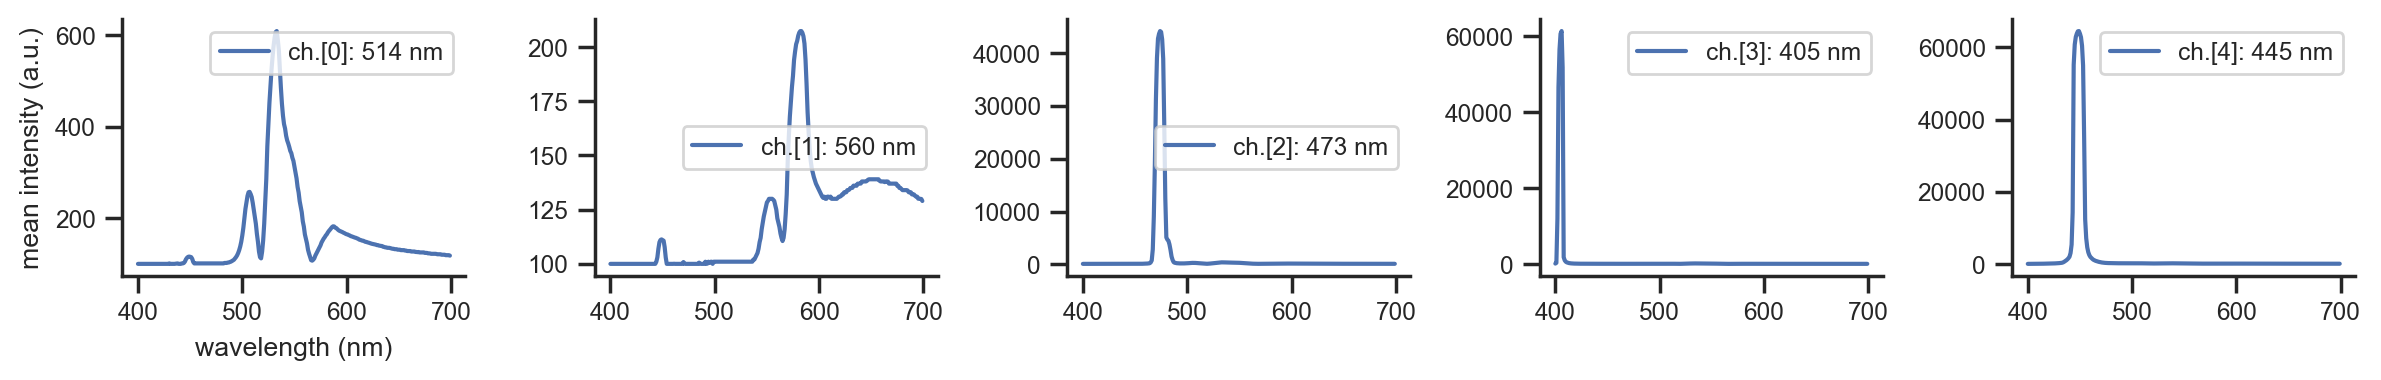

In [5]:
# plot the raw data mean per pixel
f, ax = plt.subplots(1, 5, figsize=(12, 2))
lasers_inferred = [514, 560, 473, 405, 445]
for j in range(len(xj)):
    ax[j].plot(l, np.squeeze(np.mean(f0_xj[j], axis=0)), label=f'ch.[{j}]: {lasers_inferred[j]} nm')
    ax[j].legend()
    if j == 0:
        ax[j].set(xlabel = 'wavelength (nm)', ylabel = 'mean intensity (a.u.)')

plt.tight_layout()
plt.show()

In [6]:
# The following were inferred from the above plots 
# to determine initialization for laser time series

roi_laser = [(495,515),
             (545,563),
             (468,479),
             (402,409),
             (443,455)]

for j in range(len(roi_laser)):
    roi_laser[j] = np.where(np.logical_and(l>roi_laser[j][0], l<roi_laser[j][1]))[0]

roi_indicator = np.where(np.logical_and(l>530, l<540))[0]

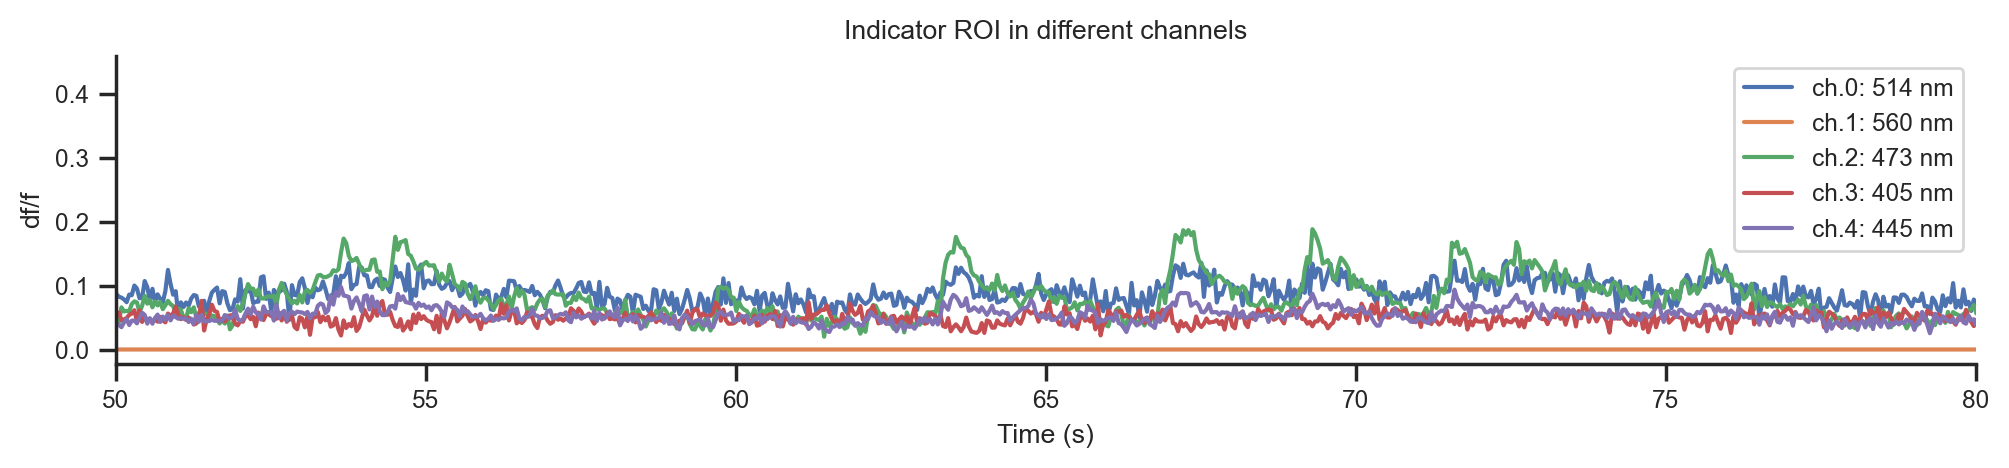

In [7]:
# there is only one indicator, so we'll look at the same roi in different channels
f, ax = plt.subplots(1,1,figsize = (12,2))
for j in range(5):
    avg_roi_rel = np.mean(rel_xj[j][:,roi_indicator], axis=1).squeeze()
    ax.plot(t, avg_roi_rel, label=f'ch.{j}: {lasers_inferred[j]} nm')
    ax.set(xlim = (50, 80), xlabel = 'Time (s)', title='Indicator ROI in different channels', ylabel = 'df/f')
plt.legend()
plt.show()

In [8]:
avg_signal_laser = {}
for j in range(len(roi_laser)):
    avg_signal_laser[j] = np.mean(rel_xj[j][:,roi_laser[j]], axis=1).squeeze()

avg_signal_indicator = np.mean(rel_xj[2][:,roi_indicator], axis=1).squeeze()

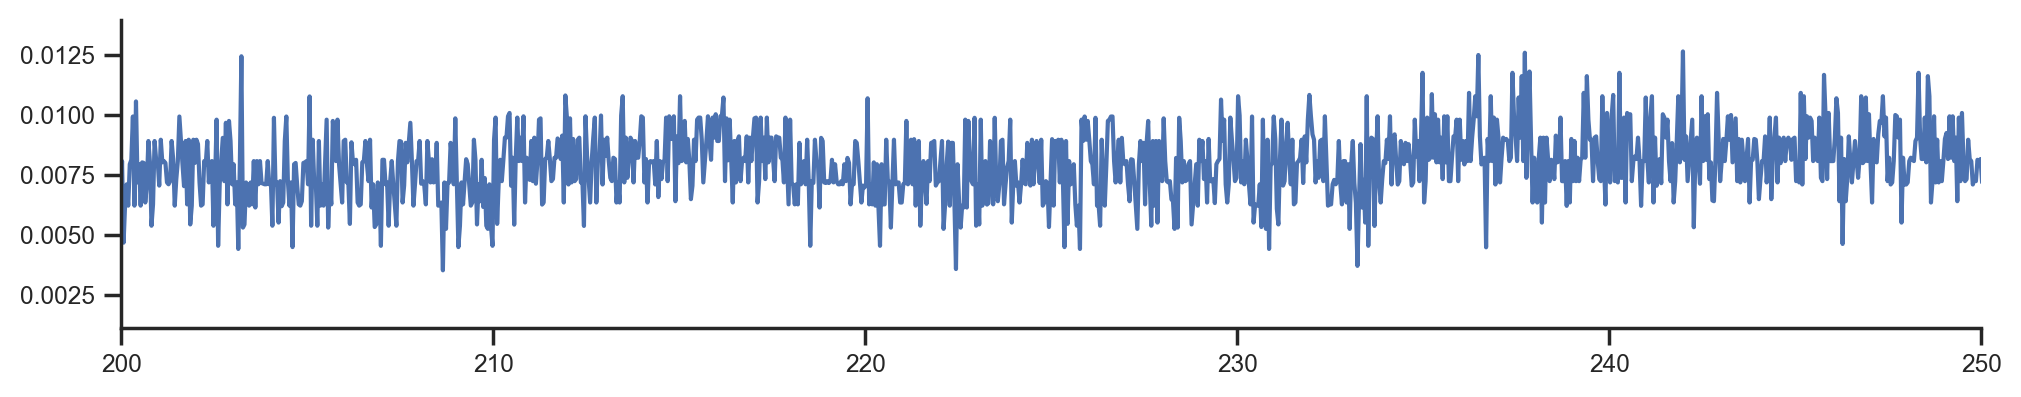

In [12]:
roi_autofl = np.where(np.logical_and(l>450, l<460))[0]
avg_signal_autofl = np.mean(rel_xj[2][:,roi_autofl], axis=1).squeeze()
f, ax = plt.subplots(1,1,figsize = (12,2))
ax.plot(t, avg_signal_autofl)
ax.set(xlim=(200,250))

[(200.0, 250.0)]

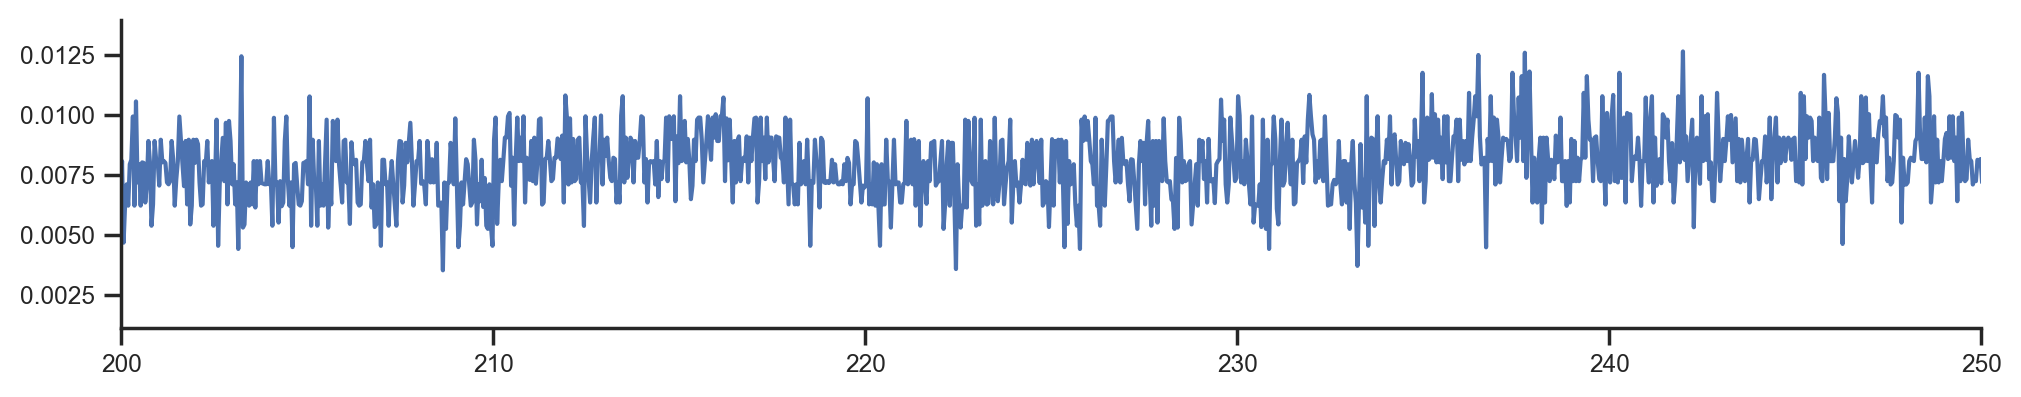

In [13]:
sources = [*[avg_signal_laser[j] for j in range(5)], avg_signal_indicator, avg_signal_autofl]
corr = np.corrcoef(sources)

src_label = ['laser 514 nm', 'laser 560 nm', 'laser 473 nm', 'laser 405 nm', 'laser 445 nm', 'Indicator', 'Autofluorescence']
df_corr = pd.DataFrame(np.round(corr, 2), columns=src_label, index=src_label)
df_corr

laser 514 nm  laser 560 nm  laser 473 nm  laser 405 nm  \
laser 514 nm              1.00          0.01          0.03          0.03   
laser 560 nm              0.01          1.00         -0.01          0.02   
laser 473 nm              0.03         -0.01          1.00          0.03   
laser 405 nm              0.03          0.02          0.03          1.00   
laser 445 nm              0.05         -0.00          0.12          0.03   
Indicator                 0.82          0.01          0.28          0.03   
Autofluorescence          0.03         -0.05          0.31         -0.01   

                  laser 445 nm  Indicator  Autofluorescence  
laser 514 nm              0.05       0.82              0.03  
laser 560 nm             -0.00       0.01             -0.05  
laser 473 nm              0.12       0.28              0.31  
laser 405 nm              0.03       0.03             -0.01  
laser 445 nm              1.00       0.06              0.05  
Indicator                 0.06       1.00              0.11  
Autofluorescence          0.05       0.11              1.00

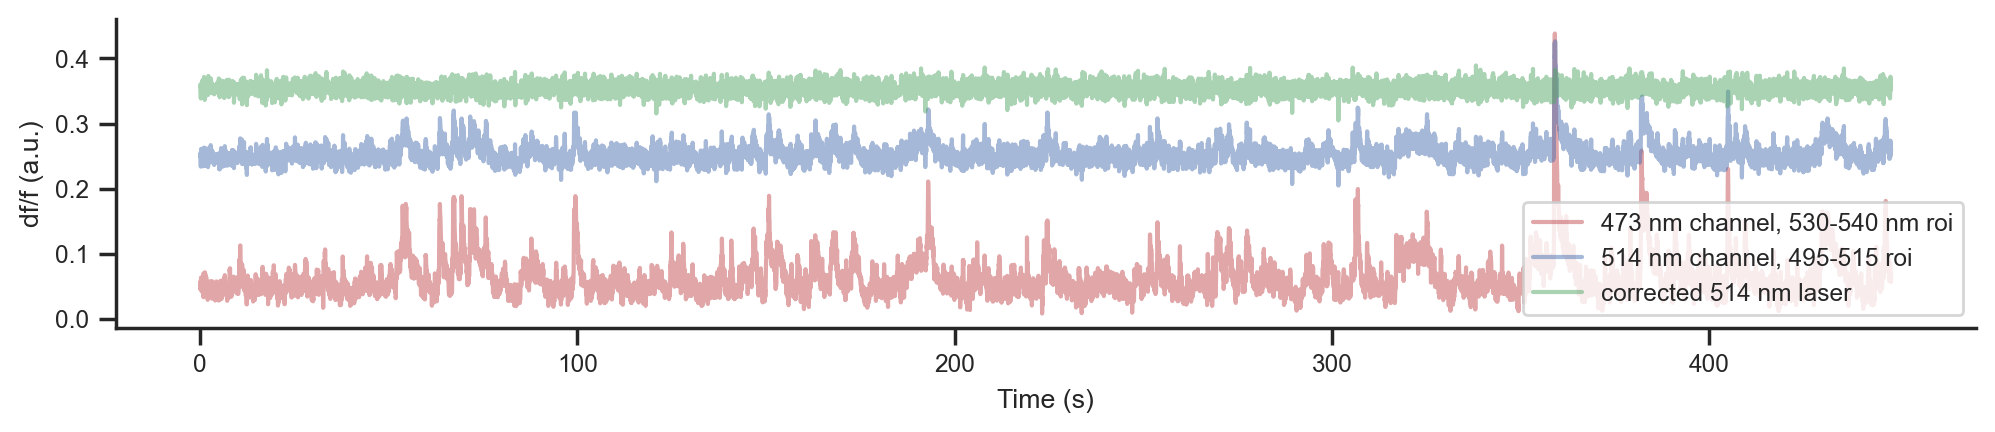

In [14]:
# removing the correlated component
a = np.copy(avg_signal_laser[0])
b = np.copy(avg_signal_indicator)
a_avg = np.mean(a)
b_avg = np.mean(b)
a = a - a_avg
b = b - b_avg
uncorr_laser_src = (a - np.dot(a,b)/np.dot(b,b) * b) + a_avg

f, ax = plt.subplots(1,1,figsize = (12,2))

ax.plot(t, np.squeeze(avg_signal_indicator), 'r', alpha=0.5, label='473 nm channel, 530-540 nm roi')
ax.plot(t, np.squeeze(avg_signal_laser[0]) + 0.2, 'b', alpha=0.5, label='514 nm channel, 495-515 roi')
ax.plot(t, np.squeeze(uncorr_laser_src) + 0.3, 'g', alpha=0.5, label='corrected 514 nm laser')
ax.set(xlabel='Time (s)', ylabel='df/f (a.u.)')
plt.legend()
plt.show()

# plots are staggered just for comparison

In [15]:
# checking if correlation is removed between laser and indicator
sources = [*[avg_signal_laser[j] for j in range(5)], avg_signal_indicator, avg_signal_autofl]
sources[0] = uncorr_laser_src
corr = np.corrcoef(sources)
src_label = ['laser 514 nm', 'laser 560 nm', 'laser 473 nm', 'laser 405 nm', 'laser 445 nm', 'Indicator', 'Autofluorescence']

df_corr = pd.DataFrame(np.round(corr, 2), columns=src_label, index=src_label)
df_corr

laser 514 nm  laser 560 nm  laser 473 nm  laser 405 nm  \
laser 514 nm              1.00          0.01         -0.35          0.02   
laser 560 nm              0.01          1.00         -0.01          0.02   
laser 473 nm             -0.35         -0.01          1.00          0.03   
laser 405 nm              0.02          0.02          0.03          1.00   
laser 445 nm              0.00         -0.00          0.12          0.03   
Indicator                -0.00          0.01          0.28          0.03   
Autofluorescence         -0.11         -0.05          0.31         -0.01   

                  laser 445 nm  Indicator  Autofluorescence  
laser 514 nm              0.00      -0.00             -0.11  
laser 560 nm             -0.00       0.01             -0.05  
laser 473 nm              0.12       0.28              0.31  
laser 405 nm              0.03       0.03             -0.01  
laser 445 nm              1.00       0.06              0.05  
Indicator                 0.06       1.00              0.11  
Autofluorescence          0.05       0.11              1.00

In [16]:
# Check normalized data across different channels
f, ax = plt.subplots(5, 1, figsize=(4, 8))
for j in range(5):
    f.colorbar(ax[j].imshow(rel_xj[j].T, interpolation='nearest', aspect='auto', vmin=0, vmax=0.2), ax=ax[j], shrink=0.5)
    ax[j].grid(visible=False)
    ax[j].set(ylabel='wavelength (nm)', xlabel='time (index)', title=f'Relative Channel {j}')
    ax[j].set_yticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])

plt.tight_layout()

In [18]:
# we have starting points for source signals based on roi
# we'll estimate the mixing matrix, by looking at correlation between sources and channels

def coef_fn(x, y):
    c = np.dot(x - np.mean(x), y - np.mean(y)) / np.size(x)
    c = c / (np.std(x)*np.std(y) + 1e-10)
    return c


def sim_fn(x, y):
    s = np.dot(x, y)
    return s


src_label = ['laser 514 nm', 'laser 560 nm', 'laser 473 nm',
             'laser 405 nm', 'laser 445 nm', 'indicator 530-540 nm',
             'autofluorescence']
n_channels = 5

f, ax = plt.subplots(len(lasers), len(sources), figsize=(12, 8))
W_list = [[] for _ in range(n_channels)]


for col, src in enumerate(sources):
    for j in range(n_channels):
        src_cc = np.array([coef_fn(src, rel_xj[j][:, px]) for px in range(rel_xj[j].shape[1])])
        # src_cc = np.array([sim_fn(src, rel_xj[j][:,px]) for px in range(rel_xj[j].shape[1])])

        # force zeros
        if (j < 5) and (col < 5):
            if j != col:
                src_cc = np.zeros_like(src_cc)

        W_list[j].append(src_cc)
        ax[j, col].plot(l, src_cc, '-b')
        ax[j, col].set(xlim=(400, 700),
                       ylim=(-0.1, 1.1),
                       title=f'channel: {lasers_inferred[j]} nm \n src: {src_label[col]}',
                       xlabel='wavelength (nm)',
                       ylabel='corr. coef.',)
plt.tight_layout()
plt.show()

In [21]:
# include channels [0,2,4]; 
# sources [0,2,4,5], and an extra one for autofluorescence
# for each channel retain only pixels in the 460 to 650 nm range

sel_channels = [0,2,4]
sel_px_channel = {}
sel_px_channel[0] = np.logical_and(l>=460, l<=650)
sel_px_channel[2] = np.logical_and(l>=460, l<=650)
sel_px_channel[4] = np.logical_and(l>=460, l<=650)

l_channels = {}
n_px_in_ch = {}
for ch in sel_channels:
    l_channels[ch] = l[sel_px_channel[ch]]
    n_px_in_ch[ch] = np.size(l_channels[ch])

sel_sources = [0,2,4,5,6]
n_sources = 5

YY = np.concatenate([rel_xj[j][:,sel_px_channel[j]] for j in sel_channels], axis=1)
YY = YY.T
print('data shape:', YY.shape)

data shape: (573, 10752)


In [22]:
# init through corr coef
AA = 0.1*np.ones((YY.shape[0], n_sources))
for idx, src_id in enumerate(sel_sources): # autofluorescence is unknown here
    a = []
    for j in sel_channels:
        a.append(W_list[j][src_id][sel_px_channel[j]])
    AA[:,idx] = np.concatenate(a, axis=0)

AA[AA<0] = 0.01

f, ax = plt.subplots(figsize=(12,2))
ax.plot(AA[:,0], label='514 nm')
ax.plot(AA[:,1], label='473 nm')
ax.plot(AA[:,2], label='415 nm')
ax.plot(AA[:,3], label='indicator')
ax.plot(AA[:,4], label='autofluorescence')
ax.set(xlabel='wavelengths x channels', ylabel='A[:,source]', ylim=(0.0,1.1))
plt.legend()
plt.tight_layout()
plt.show()

(573, 5)


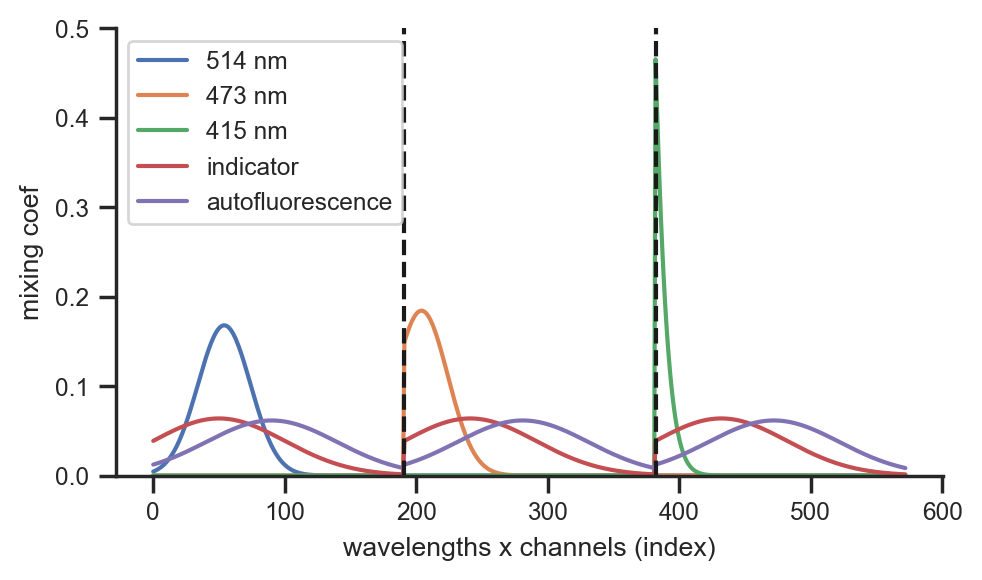

In [23]:
from scipy.stats import norm
from sourcesep.models.nmf_variants import set_norm

x = np.concatenate([l_channels[0], l_channels[2], l_channels[4]])

l1 = norm.pdf(x, loc=514, scale=20)
l1[n_px_in_ch[0]:] = 0
l1 = set_norm(l1, axis=0, c=1)[0]


l2 = norm.pdf(x, loc=473, scale=20)
l2[:n_px_in_ch[0]] = 0
l2[(n_px_in_ch[0]+n_px_in_ch[2]):] = 0
l2 = set_norm(l2, axis=0, c=1)[0]

l3 = norm.pdf(x, loc=415, scale=20)
l3[:(n_px_in_ch[0]+n_px_in_ch[2])] = 0
l3 = set_norm(l3, axis=0, c=1)[0]

indicator = norm.pdf(x, loc=510, scale=50)
indicator = set_norm(indicator, axis=0, c=1)[0]

autofl = norm.pdf(x, loc=550, scale=50)
autofl = set_norm(autofl, axis=0, c=1)[0]

f, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(np.arange(x.size), l1, label='514 nm')
ax.plot(np.arange(x.size), l2, label='473 nm')
ax.plot(np.arange(x.size), l3, label='415 nm')
ax.plot(np.arange(x.size), indicator, label='indicator')
ax.plot(np.arange(x.size), autofl, label='autofluorescence')

ax.axvline(n_px_in_ch[0], color='k', linestyle='--')
ax.axvline(n_px_in_ch[0]+n_px_in_ch[2], color='k', linestyle='--')

ax.set(xlabel='wavelengths x channels (index)',
       ylabel='mixing coef', 
       ylim=(0.0, 0.5))
plt.legend()
plt.tight_layout()

A_init_0 = np.vstack([l1, l2, l3, indicator, autofl]).T
A_init_0 = set_norm(A_init_0, axis=0, c=1.0)[0]
print(A_init_0.shape)


In [24]:
A_keep = np.zeros_like(AA).astype(bool)
A_keep[:n_px_in_ch[0], 0] = True  # laser in channel 0
A_keep[n_px_in_ch[0]:n_px_in_ch[0] + n_px_in_ch[2], 1] = True  # laser in channel 2
A_keep[n_px_in_ch[0]+n_px_in_ch[2]:, 2] = True  # laser in channel 4
A_keep[:, 3] = True  # indicator
A_keep[:, 4] = True  # autofluorescence

f, ax = plt.subplots(figsize=(4, 2))
sns.heatmap(A_keep.T, cmap='viridis', ax=ax)
ax.set(xlabel='wavelengths x channels (index)', ylabel='source (index)')
plt.show()

In [25]:
XX = np.ones((n_sources, YY.shape[1]))

for idx, src_id in enumerate(sel_sources):
    XX[idx,:] = sources[src_id]

XX = set_norm(XX, axis=1, c=10.0)[0]

f, ax = plt.subplots(5,1,figsize=(12,5))
ax[0].plot(t, XX[0,:].ravel(), label='514 nm')
ax[1].plot(t, XX[1,:].ravel(), label='473 nm')
ax[2].plot(t, XX[2,:].ravel(), label='415 nm')
ax[3].plot(t, XX[3,:].ravel(), label='indicator')
ax[4].plot(t, XX[4,:].ravel(), label='autofluorescence')
ax[4].set(xlabel='wavelengths x channels', ylabel='X[source,:]')

#show legend for all subplots
for i in range(5):
    ax[i].legend(bbox_to_anchor=(1.00, 1.00), loc='upper right')

plt.tight_layout()
plt.show()

In [26]:
X_init_0 = 1.0+0.1*np.random.randn(XX.shape[0], XX.shape[1])
X_init_0[X_init_0<1e-2] = 1e-2
X_init_0 = set_norm(X_init_0, axis=1, c=1.0)[0]

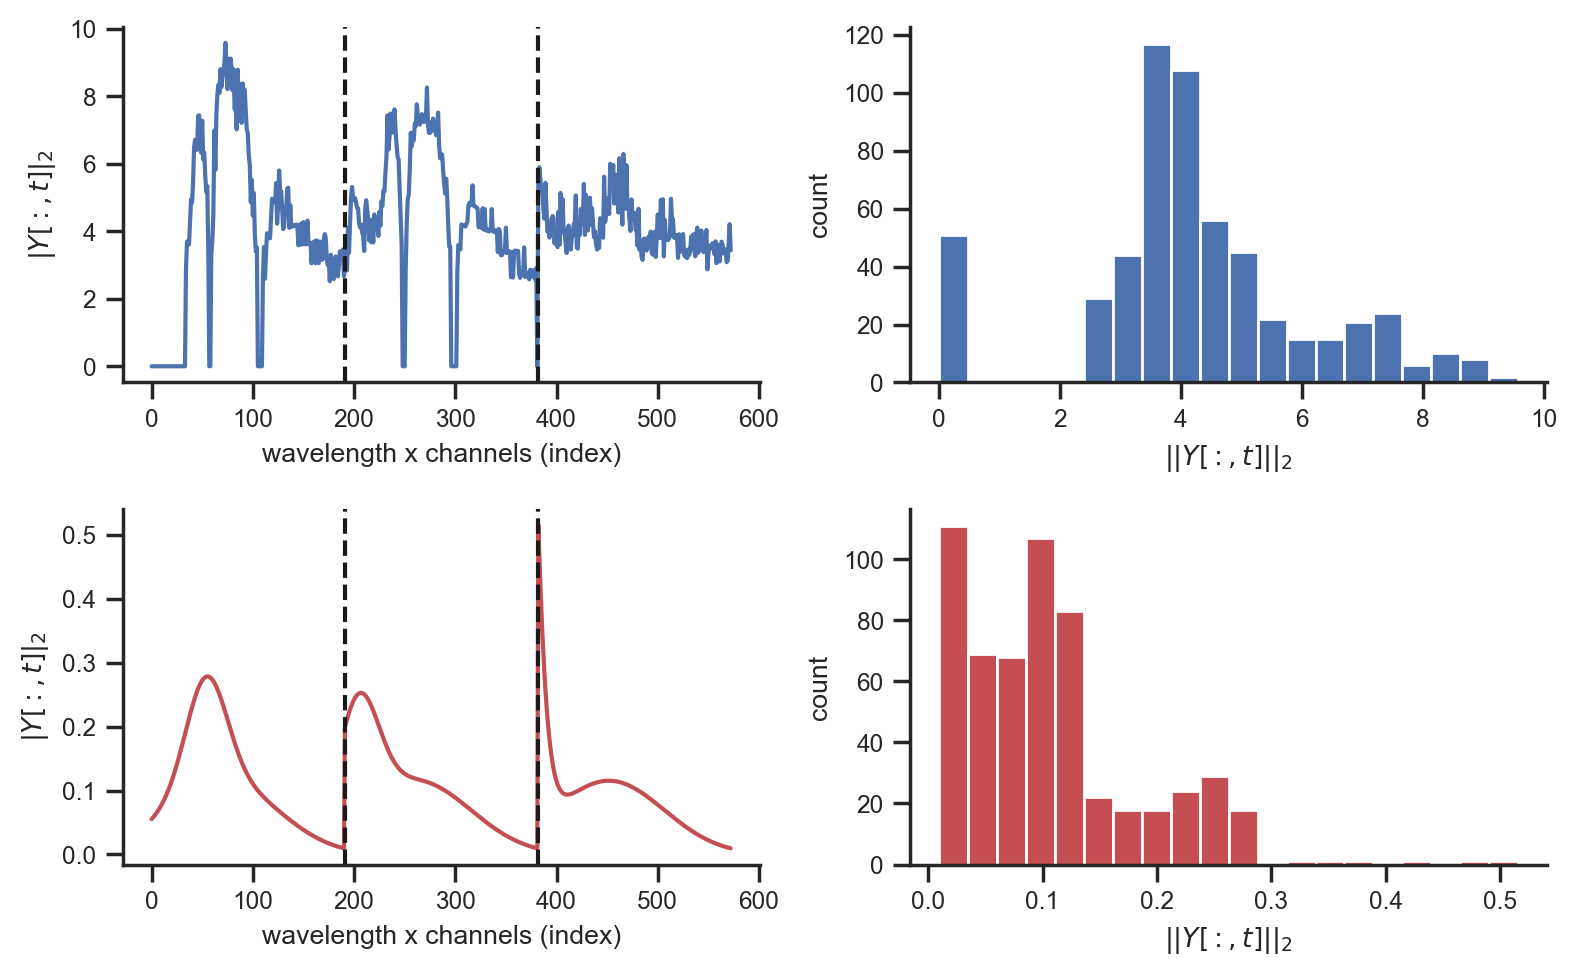

data median norm = 4.04 
 init median norm = 0.10
set norm = 6.471


In [27]:
f, ax = plt.subplots(2,2,figsize=(8,5))

norm_Y = np.linalg.norm(YY, ord=2, axis=1)
ax[0,0].plot(norm_Y)
ax[0,0].set(xlabel='wavelength x channels (index)', ylabel=r'$|Y[:,t]|_2$')
ax[0,0].axvline(n_px_in_ch[0], color='k', linestyle='--')
ax[0,0].axvline(n_px_in_ch[0]+n_px_in_ch[2], color='k', linestyle='--')

ax[0,1].hist(norm_Y, bins=20)
ax[0,1].set(xlabel=r'$||Y[:,t]||_2$', ylabel='count')

Y_init_0 = set_norm(A_init_0,axis=0,c=1.0)[0] @ set_norm(X_init_0,axis=1,c=1.0)[0]

norm_Y_init_0 = np.linalg.norm(Y_init_0, ord=2, axis=1)
ax[1,0].plot(norm_Y_init_0, c='r')
ax[1,0].set(xlabel='wavelength x channels (index)', ylabel=r'$|Y[:,t]|_2$')
ax[1,0].axvline(n_px_in_ch[0], color='k', linestyle='--')
ax[1,0].axvline(n_px_in_ch[0]+n_px_in_ch[2], color='k', linestyle='--')

ax[1,1].hist(norm_Y_init_0, bins=20, color='r')
ax[1,1].set(xlabel=r'$||Y[:,t]||_2$', ylabel='count')

plt.tight_layout()
plt.show()

print(f'data median norm = {np.median(norm_Y):0.2f} \n init median norm = {np.median(norm_Y_init_0):0.2f}')
print(f'set norm = {np.sqrt(np.median(norm_Y)/ np.median(norm_Y_init_0)):0.3f}')
# top row is for input data
# bottom row is for the initialization.
# We'll set the initialization close to the 

In [28]:
import pickle
print(f'YY: {YY.shape}')
print(f'AA: {AA.shape}')
print(f'XX: {XX.shape}')

dat = dict(Y=YY,
           A_corr=set_norm(AA, axis=0, c=1.0)[0].copy(),
           X_roi=set_norm(XX, axis=1, c=1.0)[0].copy(),
           A_keep=A_keep.copy(),
           X_keep=None,
           A_init_0=set_norm(A_init_0, axis=0, c=6.5)[0].copy(),
           X_init_0=set_norm(X_init_0, axis=1, c=6.5)[0].copy(),
           l_channels=l_channels,
           n_px_in_ch=n_px_in_ch,
           l=l,
           t=t)

fname = paths['root'] / 'sims' / 'nmf_single_indicator_test_data_autofl.pkl'
with open(fname, 'wb') as f:
    pickle.dump(dat, f)

YY: (573, 10752)
AA: (573, 5)
XX: (5, 10752)


The basic recipe:
 - warm up with fitting of X (no sparsity or deviation penalties)
 - use `step_size=1.0`, `tol=1e-2` (we use gradient clipping internally to stabilize)
 - relatively large `tol` prevents zeroing values/ permits recovery
 - fit A and X together with a schedule to reduce `step_size` over iterations
 - reduce `tol` to very small values as the fit progresses

On this dataset, an `log10(error)=1.253` provides an interpretable fit, that roughly matches X_roi and A_corr above

X and A are initialized, ignoring rank.


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


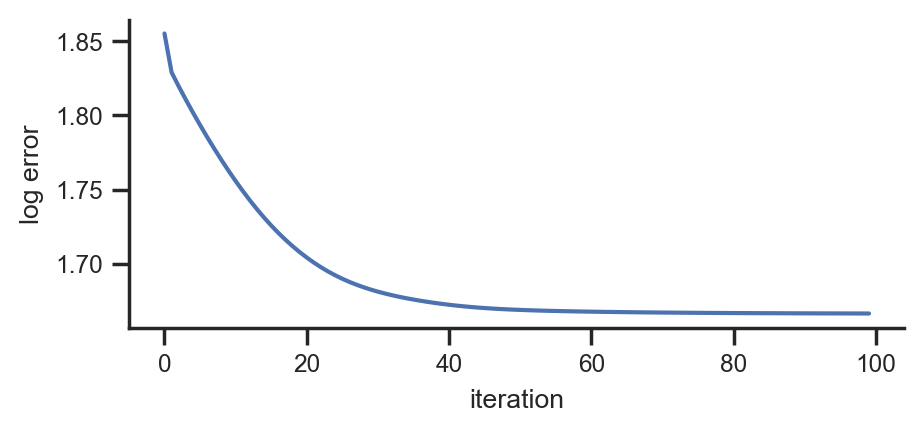

X and A are initialized, ignoring rank.


100%|██████████| 500/500 [01:05<00:00,  7.68it/s]


X and A are initialized, ignoring rank.


100%|██████████| 500/500 [01:04<00:00,  7.69it/s]


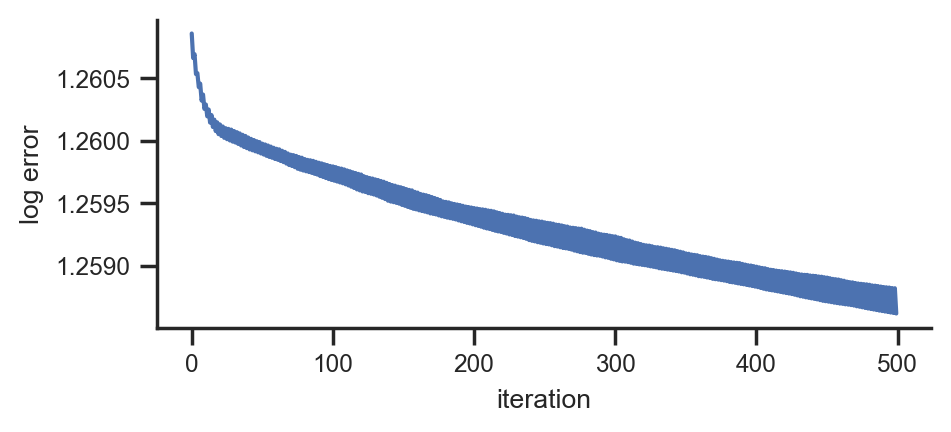

X and A are initialized, ignoring rank.


100%|██████████| 500/500 [01:05<00:00,  7.62it/s]


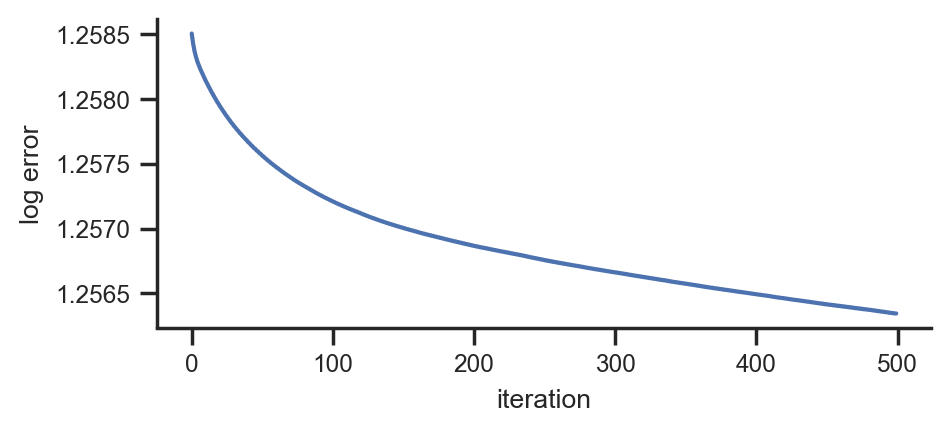

X and A are initialized, ignoring rank.


 30%|███       | 610/2000 [01:19<03:01,  7.64it/s]


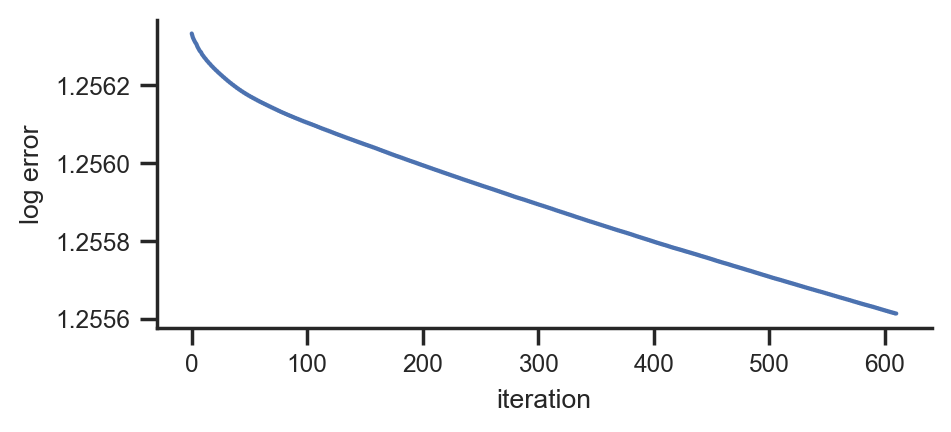

X and A are initialized, ignoring rank.


100%|██████████| 4000/4000 [08:42<00:00,  7.65it/s]


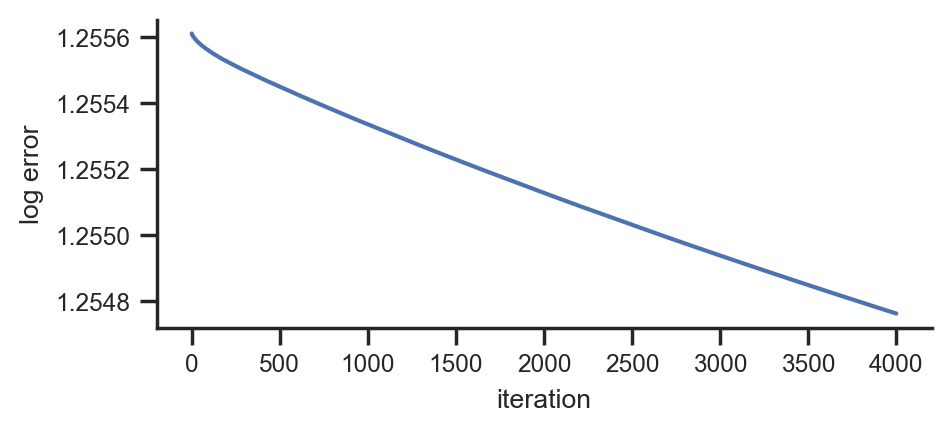

In [23]:
%autoreload 2
from sourcesep.models.nmf_variants import nmf_recipe_02, set_norm

A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=dat['A_init_0'].copy(), X=dat['X_init_0'].copy(), rank=5,
                                A_keep=dat['A_keep'], X_keep=None, grad_type=None,
                                step_size_A=1.0, step_size_X=1.0,
                                lam_sparsity_x=0.0, lam_2norm_x = 0.00, lam_deviation_x = 0.0,
                                fit_A=False, fit_X=True,
                                tol=1e-2, exit_tol=1e-7, max_iter=100)

res_warmup = {'A':A.copy(), 'X':X.copy(), 'err':err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_warmup['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

# -------------------------------------------------------------------------------------------------------------
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_warmup['A'].copy(), X=res_warmup['X'].copy(), rank=5,
                                A_keep=dat['A_keep'], X_keep=None, grad_type=None,
                                step_size_A=0.1, step_size_X=0.1,
                                lam_sparsity_x=0.0, lam_2norm_x = 0.00, lam_deviation_x = 0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-4, exit_tol=1e-7, max_iter=500)

res_fine_tune_0 = {'A':A.copy(), 'X':X.copy(), 'err':err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_0['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

# -------------------------------------------------------------------------------------------------------------
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_fine_tune_0['A'].copy(), X=res_fine_tune_0['X'].copy(), rank=5,
                                A_keep=dat['A_keep'], X_keep=None, grad_type=None,
                                step_size_A=0.05, step_size_X=0.05,
                                lam_sparsity_x=0.0, lam_2norm_x = 0.00, lam_deviation_x = 0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-5, exit_tol=1e-7, max_iter=500)

res_fine_tune_1 = {'A':A.copy(), 'X':X.copy(), 'err':err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_1['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

# -------------------------------------------------------------------------------------------------------------
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_fine_tune_1['A'].copy(), X=res_fine_tune_1['X'].copy(), rank=5,
                                A_keep=dat['A_keep'], X_keep=None, grad_type=None,
                                step_size_A=0.01, step_size_X=0.01,
                                lam_sparsity_x=0.0, lam_2norm_x = 0.00, lam_deviation_x = 0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-6, exit_tol=1e-7, max_iter=500)

res_fine_tune_2 = {'A':A.copy(), 'X':X.copy(), 'err':err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_2['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()


# -------------------------------------------------------------------------------------------------------------
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_fine_tune_2['A'].copy(), X=res_fine_tune_2['X'].copy(), rank=5,
                                A_keep=A_keep, X_keep=None, grad_type=None,
                                step_size_A=0.005, step_size_X=0.005,
                                lam_sparsity_x=0.0, lam_2norm_x = 0.00, lam_deviation_x = 0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-7, exit_tol=1e-8, max_iter=2000)

res_fine_tune_3 = {'A':A.copy(), 'X':X.copy(), 'err':err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_3['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')

#save without showing the plot


# -------------------------------------------------------------------------------------------------------------
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_fine_tune_3['A'].copy(), X=res_fine_tune_3['X'].copy(), rank=5,
                                A_keep=A_keep, X_keep=None, grad_type=None,
                                step_size_A=0.001, step_size_X=0.001,
                                lam_sparsity_x=0.0, lam_2norm_x = 0.00, lam_deviation_x = 0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-8, exit_tol=1e-8, max_iter=4000)

res_fine_tune_4 = {'A':A.copy(), 'X':X.copy(), 'err':err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_4['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

# -------------------------------------------------------------------------------------------------------------
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_fine_tune_4['A'].copy(), X=res_fine_tune_4['X'].copy(), rank=5,
                                A_keep=A_keep, X_keep=None, grad_type=None,
                                step_size_A=0.0005, step_size_X=0.0005,
                                lam_sparsity_x=0.0, lam_2norm_x = 0.00, lam_deviation_x = 0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-9, exit_tol=1e-9, max_iter=16000)

res_fine_tune_5 = {'A':A.copy(), 'X':X.copy(), 'err':err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_5['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()


X and A are initialized, ignoring rank.


100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


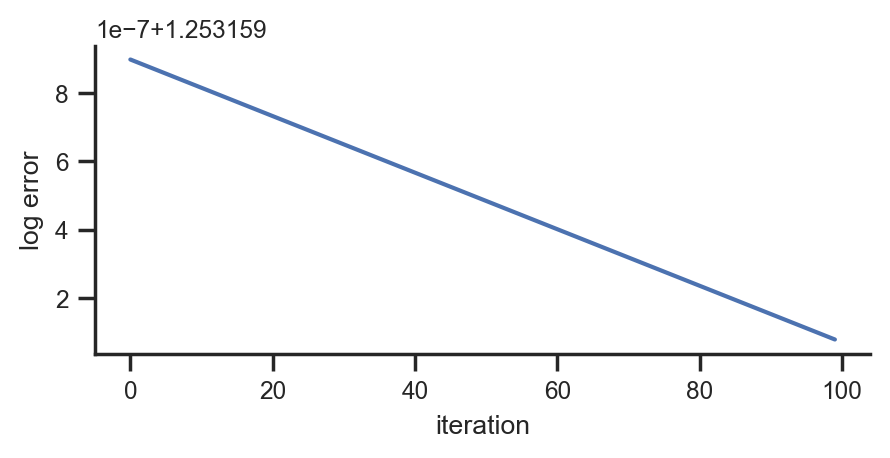

In [90]:
# -------------------------------------------------------------------------------------------------------------
A, X, err, init = nmf_recipe_02(dat['Y'].copy(), A=res_fine_tune_8['A'].copy(), X=res_fine_tune_8['X'].copy(), rank=5,
                                A_keep=A_keep, X_keep=None, grad_type=None,
                                step_size_A=0.0001, step_size_X=0.0001,
                                lam_sparsity_x=0.0, lam_2norm_x = 0.00, lam_deviation_x = 0.0,
                                fit_A=True, fit_X=True,
                                tol=1e-9, exit_tol=1e-8, max_iter=100)

res_fine_tune_8 = {'A':A.copy(), 'X':X.copy(), 'err':err}

f, ax = plt.subplots(1,1,figsize=(5,2))
ax.plot(np.log10(res_fine_tune_8['err']))
ax.set(xlabel = 'iteration', ylabel = 'log error')
plt.show()

In [91]:
# heatmap of dat['Y']a
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
data = dat['Y']
sns.heatmap(data, cmap='viridis', ax=ax[0], vmin=0.0, vmax=0.3)
ax[0].set(xlabel='time', ylabel='wavelengths x channels')

data = dat['A_init_0'] @ dat['X_init_0']
sns.heatmap(data, cmap='viridis', ax=ax[1], vmin=0.0, vmax=0.3)
ax[1].set(xlabel='time', ylabel='wavelengths x channels')

data = res_fine_tune_5['A'] @ res_fine_tune_5['X']
sns.heatmap(data, cmap='viridis', ax=ax[2], vmin=0.0, vmax=0.3)
ax[2].set(xlabel='time', ylabel='wavelengths x channels')

plt.tight_layout()
plt.show()

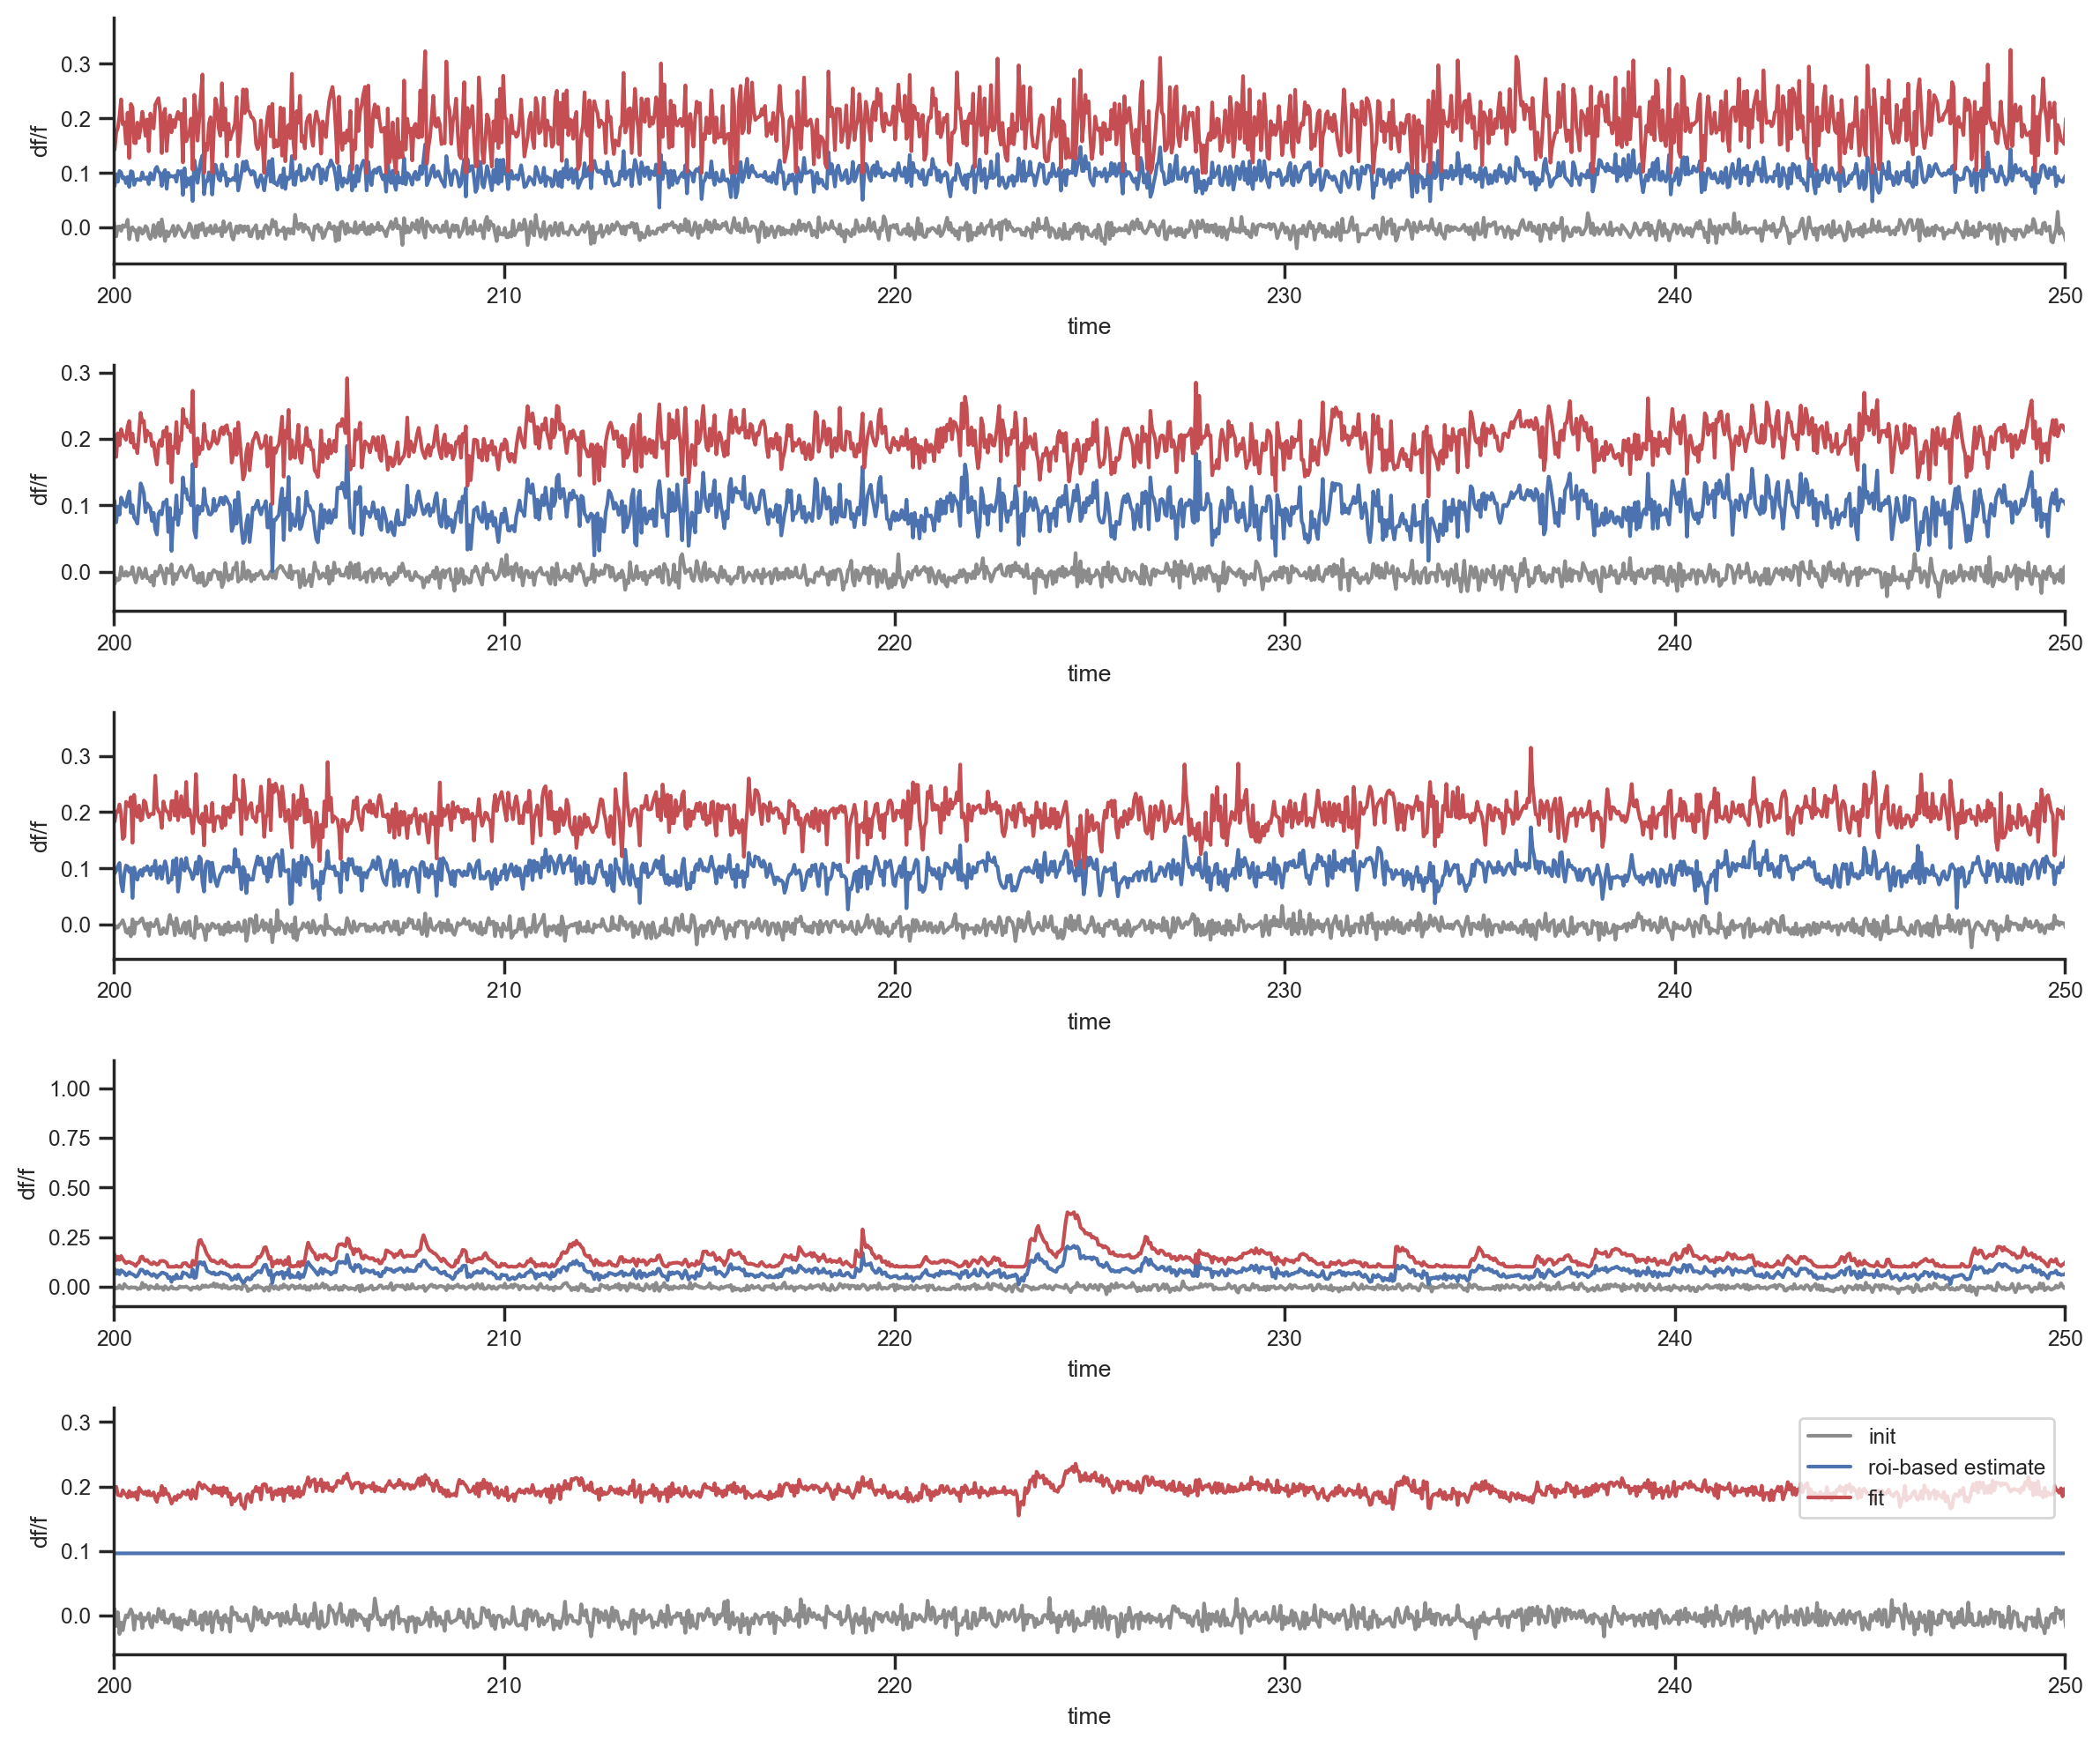

In [92]:
X_init = set_norm(dat['X_init_0'], axis=1, c=10.0)[0]
X_aprx = set_norm(dat['X_roi'], axis=1, c=10.0)[0]
X_fit = set_norm(res_fine_tune_8['X'], axis=1, c=10.0)[0]

f, ax = plt.subplots(5,1,figsize=(12,10))
for s in range(5):
    ax[s].plot(t, X_init[s,:]-0.1, c='k', alpha = 0.5, label='init')
    ax[s].plot(t, X_aprx[s,:], c='b', label='roi-based estimate')
    ax[s].plot(t, X_fit[s,:] + 0.1, c='r', label='fit')
    ax[s].set(xlabel='time', ylabel='df/f', xlim=[200,250])
plt.legend()
plt.tight_layout()
plt.show()

In [93]:
A_init = set_norm(dat['A_init_0'], axis=0, c=10.0)[0]
A_aprx = set_norm(dat['A_corr'], axis=0, c=10.0)[0]
A_fit = set_norm(res_fine_tune_8['A'], axis=0, c=10.0)[0]


f, ax = plt.subplots(5,1,figsize=(12,10))
for s in range(5):
    ax[s].plot(A_init[:,s].T-0.1, c='k', alpha = 0.5, label='init')
    ax[s].plot(A_aprx[:,s].T, c='b', label='correlation estimate')
    ax[s].plot(A_fit[:,s].T + 0.1, c='r', label='fit')
    ax[s].set(xlabel='wavelength', ylabel='amplitude', ylim=(-0.2, 2.2))
    ax[s].axvline(dat['n_px_in_ch'][0], color='k', linestyle='--')
    ax[s].axvline(dat['n_px_in_ch'][0]+dat['n_px_in_ch'][2], color='k', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
results = {'res_warmup': res_warmup,
            'res_fine_tune_0': res_fine_tune_0,
            'res_fine_tune_1': res_fine_tune_1,
            'res_fine_tune_2': res_fine_tune_2,
            'res_fine_tune_3': res_fine_tune_3,
            'res_fine_tune_4': res_fine_tune_4,
            'res_fine_tune_5': res_fine_tune_5,
            'res_fine_tune_6': res_fine_tune_6,
            'res_fine_tune_7': res_fine_tune_7,
            'res_fine_tune_8': res_fine_tune_8}

fname = paths['root'] / 'results/00_nmf_single_indicator_fit_nb.pkl'
with open(fname, 'wb') as f:
    pickle.dump(results, f)